# Machine learning model to predict if Kobe Bryant is going to score (LGBM)

In [1]:
seed = 42
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)
import pandas as pd
from logzero import logger
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import pickle
import matplotlib.pyplot as plt
import itertools
import shap 
import seaborn as sns

grid_search = False

df = pd.read_csv('data.csv')

df.dropna(inplace=True)


In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Data description

In [3]:
df.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

In [4]:
df

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30692
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


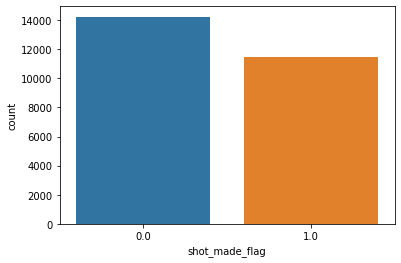

In [5]:
sns.countplot(x='shot_made_flag', data=df)
#No balancing issues

Text(0.5, 1.0, 'lat and lon')

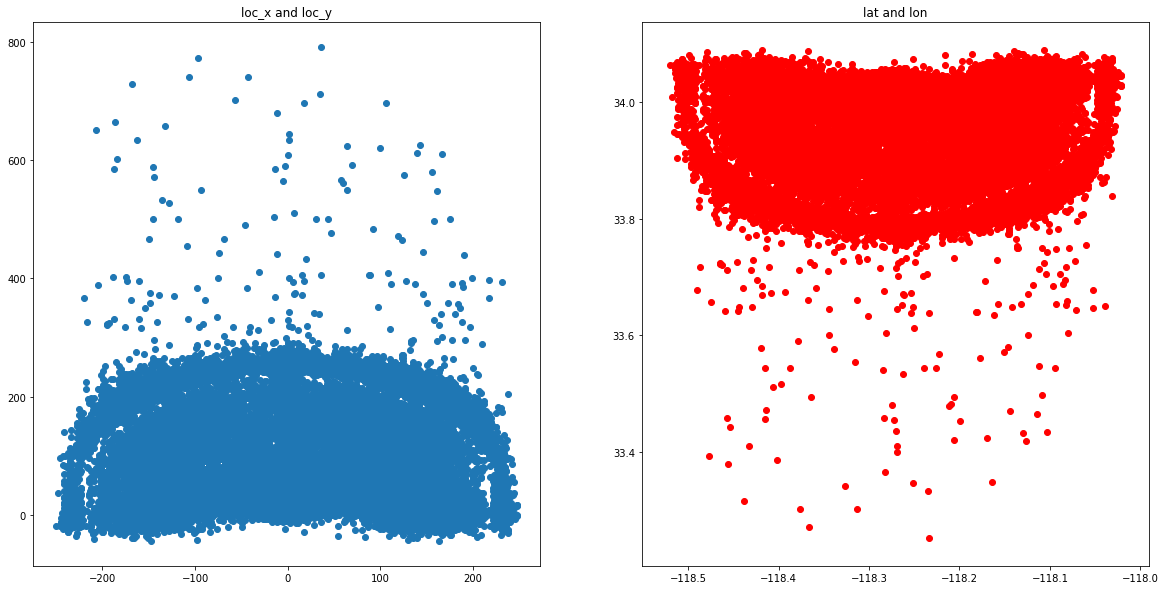

In [6]:
plt.figure(figsize=(20,10))

# loc_x and loc_y
plt.subplot(1, 2, 1)
plt.scatter(df.loc_x, df.loc_y)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(1, 2, 2)
plt.scatter(df.lon, df.lat, color= 'red')
plt.title('lat and lon')

#Correlation between (lat and long) and (loc_x and loc_y)

In [7]:
df.action_type.value_counts(dropna=False)*100/len(df)
#Percentage of occurencies of action type, 96% of action types are in the 15 firsts, the others are rare

Jump Shot                          61.625871
Layup Shot                          8.382301
Driving Layup Shot                  6.335370
Turnaround Jump Shot                3.467331
Fadeaway Jump Shot                  3.393392
Running Jump Shot                   3.031482
Pullup Jump shot                    1.564385
Turnaround Fadeaway shot            1.424291
Slam Dunk Shot                      1.299763
Reverse Layup Shot                  1.295871
Jump Bank Shot                      1.124645
Driving Dunk Shot                   1.000117
Dunk Shot                           0.844457
Tip Shot                            0.587617
Step Back Jump shot                 0.412500
Alley Oop Dunk Shot                 0.369693
Floating Jump shot                  0.361910
Driving Reverse Layup Shot          0.322995
Hook Shot                           0.284080
Driving Finger Roll Shot            0.264622
Alley Oop Layup shot                0.260731
Reverse Dunk Shot                   0.237382
Driving Fi

# Transformer

In [8]:
class KobeModel():

    def __init__(self, target: str = 'shot_made_flag'):

        """
        Class to create dataset for training/testing of machine learning algorithm for Kobe Bryant shot prediction.

        It will create X and y, the features and target
        Possibility to tune the dataset with normalization, balance, or temporality


        Return X, y features and target shot result
        """
        self.cols_to_dummies = ['shot_type', 'shot_zone_area',
                                'shot_zone_basic', 'shot_zone_range','action_type']
        self.col_to_label = ['opponent', 'combined_shot_type']
        self.to_norm = []
        self.past_features = []
        self.target = target

    @classmethod
    def add_temporality(self, df: pd.DataFrame, features: list, win: int = 20) -> pd.DataFrame:
        """
        Add features variation based on a rolling window mean

        Parameters
        ----------
        df: Dataframe
        features: list of mnemonics to add temporal feature
        Returns
        -------
        df: pd.Dataframe with temporal features
        """
        for FEAT in features:
            df[FEAT + '_5'] = (df[FEAT] - df[FEAT].rolling(window=int(win), min_periods=0).mean()).bfill()
        return df

    @classmethod
    def shift_values(self, df: pd.DataFrame, features: list):

        for FEAT in features:
            for i in range(1, 5):
                df[FEAT + '_shift' + str(i)] = df[FEAT].shift(i).bfill()
        return df


    @classmethod
    def normalize_features(self, df, to_norm: list) -> pd.DataFrame:
        """
        Normalize features

        Parameters
        ----------
        df: pd.DataFrame
        features: list of feature to normalize
        Returns
        -------
        df: pd.Dataframe with normalized features
        """
        for FEAT in to_norm:
            df[FEAT] = (df[FEAT] - df[FEAT].mean()) / df[FEAT].std()
        return df

    @classmethod
    def balance_dataset(self, X: pd.DataFrame, y: pd.Series, OVERSAMPLING=True) -> pd.DataFrame:

        """
        Balance the dataset
        Parameters
        ----------
        X: pd.DataFrame of features
        y: pd.Series of target
        OVERSAMPLING: if True the strategy is Oversampling else it's Undersampling
        Returns
        -------
        X: pd.Dataframe of resampled features
        y: pd.Series of resampled target
        """
        logger.info('BALANCING DATASET')
        sample = RandomOverSampler(sampling_strategy='minority') if OVERSAMPLING else RandomUnderSampler(
                sampling_strategy='majority')
        X, y = sample.fit_resample(X, y)

        return X, y

    def transform(self, df: pd.DataFrame,
                        NORM=False,
                        TEMPO=False) -> pd.DataFrame:
        """
        Create/Modify the dataset according to a feature engineering
        Parameters
        ----------
        X: pd.DataFrame
        past_mnemonics: list of mnemonics to add temporal feature
        feature: list of feature to correct and fill
        NORM: boolean if True, apply normalisation to feature
        TEMPO: boolean if True, apply temporality to past_mnemonics
        Returns
        -------
        X: pd.Dataframe with feature engineering
        y: the target
        """
        logger.info('TRANSFORMING DATASET')

        if 'matchup' in df.columns:
            df['home'] = df['matchup'].str.contains('vs').astype('int')  # 1 if home play else 0

        if 'action_type' in df.columns:
            action_types = df['action_type'].value_counts().index.values[:10]  # 96% of action type are in the 15 first (of 57) actions
            df.loc[~df['action_type'].isin(action_types), 'action_type'] = 'Other'

        for col in self.cols_to_dummies:
            if col in df.columns:
                df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
                df.drop(columns=col, inplace=True,  errors='ignore')

        le = LabelEncoder()
        for col in self.col_to_label:
            if col in df.columns:
                df[col] = le.fit_transform(df[col])

        if 'game_date' in df.columns:
            df['game_date'] = pd.to_datetime(df['game_date'])
            df['exp_year'] = df['game_date'].dt.year - df['game_date'].dt.year.min() #number of year of career
            df['game_month'] = df['game_date'].dt.month
            df.drop(columns='game_date', inplace=True, errors='ignore')

        df = self.normalize_features(df, to_norm=self.to_norm) if NORM else df
        df = self.add_temporality(df, features=self.past_features) if TEMPO else df
        df = self.shift_values(df, features=self.past_features) if TEMPO else df

        df.drop(columns=['game_event_id', 'game_id', 'team_name', 'team_id', 'matchup', 'shot_id', 'season',
                         'loc_x', 'loc_y', 'playoffs'],
                inplace=True,  errors='ignore') #Drop usless/redondant features


        return df


    def fit_transform(self, df, BALANCE=False):

        df = self.transform(df)

        X = df.drop(columns=self.target, errors='ignore')

        #X = X[['minutes_remaining', 'shot_distance', 'lat', 'lon']] #for app purpose

        y = df[self.target] if self.target in df.columns else 0

        if BALANCE:
            X, y = self.balance_dataset(X, y)

        return X, y


# Transforming and training the model

In [9]:
X, y = KobeModel().fit_transform(df,
                                    BALANCE=False)

X_train, X_test, y_train, y_test = train_test_split(X, y
                                                        ,test_size=0.3,
                                                        random_state=seed,
                                                        shuffle=True)

[I 200817 12:27:04 <ipython-input-8-6c84c0d6007c>:103] TRANSFORMING DATASET


In [10]:
params = {'objective' :'binary',
          'n_estimators' : 1000,
          'max_depth' : 10,
          'learning_rate' : 0.01,
          'random_state' :seed,
          'reg_alpha' : 10,
          'reg_lambda' : 0,
          'colsample_bytree' : 1}

lgbm = LGBMClassifier(**params)


In [11]:
logger.info('Training Model')
lgbm.fit(X_train, y_train)

[I 200817 12:27:04 <ipython-input-11-fb1826ac4bf8>:1] Training Model


LGBMClassifier(colsample_bytree=1, learning_rate=0.01, max_depth=10,
               n_estimators=1000, objective='binary', random_state=42,
               reg_alpha=10, reg_lambda=0)

# Evaluate the model

In [12]:
logger.info('Evaluating Model Results')

for name,score in zip(X_test.columns, lgbm.feature_importances_):
  print(name,score)

[I 200817 12:27:06 <ipython-input-12-e699617fc958>:1] Evaluating Model Results


combined_shot_type 1000
lat 4206
lon 5895
minutes_remaining 2513
period 874
seconds_remaining 5070
shot_distance 2299
opponent 4279
home 137
shot_type_2PT Field Goal 0
shot_type_3PT Field Goal 0
shot_zone_area_Back Court(BC) 0
shot_zone_area_Center(C) 2
shot_zone_area_Left Side Center(LC) 3
shot_zone_area_Left Side(L) 0
shot_zone_area_Right Side Center(RC) 0
shot_zone_area_Right Side(R) 28
shot_zone_basic_Above the Break 3 82
shot_zone_basic_Backcourt 0
shot_zone_basic_In The Paint (Non-RA) 19
shot_zone_basic_Left Corner 3 4
shot_zone_basic_Mid-Range 6
shot_zone_basic_Restricted Area 0
shot_zone_basic_Right Corner 3 0
shot_zone_range_16-24 ft. 93
shot_zone_range_24+ ft. 0
shot_zone_range_8-16 ft. 89
shot_zone_range_Back Court Shot 0
shot_zone_range_Less Than 8 ft. 0
action_type_Driving Layup Shot 136
action_type_Fadeaway Jump Shot 160
action_type_Jump Shot 499
action_type_Layup Shot 296
action_type_Other 49
action_type_Pullup Jump shot 97
action_type_Reverse Layup Shot 61
action_type_R

In [13]:
eval_y =lgbm.predict(X_test)

print({'TEST SCORE': lgbm.score(X_test, y_test), 'TRAIN SCORE': lgbm.score(X_train, y_train), 
      'ROC_AUC' : roc_auc_score(y_test, eval_y) })

{'TEST SCORE': 0.6769130998702984, 'TRAIN SCORE': 0.6974481570022795, 'ROC_AUC': 0.6549039807693788}


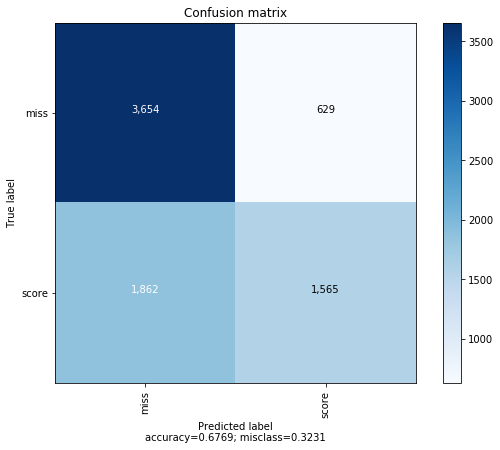

In [14]:
conf_mx = confusion_matrix(y_test, eval_y)
plot_confusion_matrix(conf_mx,target_names = ['miss', 'score'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [15]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


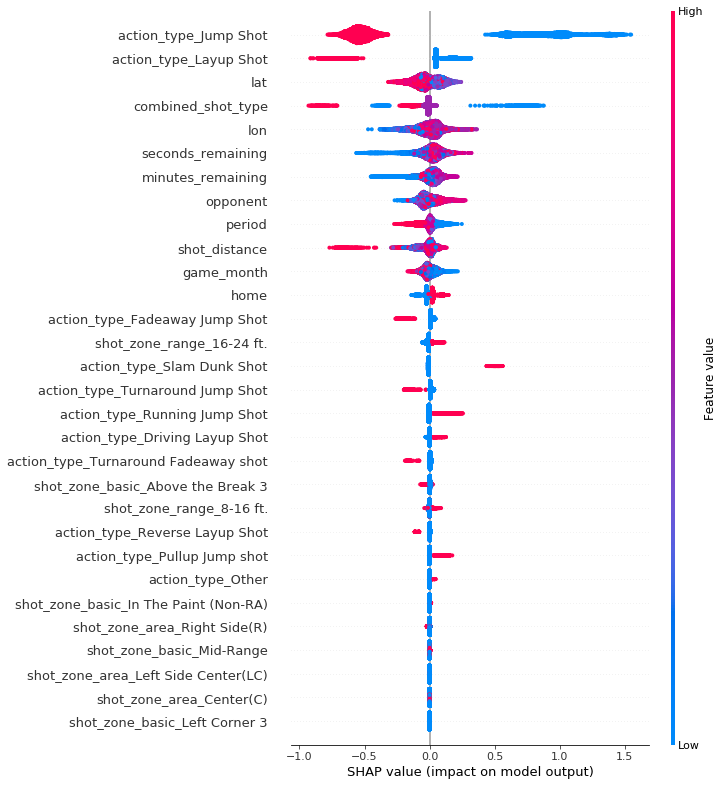

In [16]:
shap.summary_plot(shap_values[1], X_train, max_display=30)

In [17]:
print(classification_report(y_test, eval_y))

              precision    recall  f1-score   support

         0.0       0.66      0.85      0.75      4283
         1.0       0.71      0.46      0.56      3427

    accuracy                           0.68      7710
   macro avg       0.69      0.65      0.65      7710
weighted avg       0.69      0.68      0.66      7710

